# S3: AirBnb NYC 2024 Listings
by: Tam Trinh           
April 6, 2025         

<a id="0"></a> <br>
## Table of Contents  

- [Sprint Goals](#6)
- [Introduction](#1)
- [Set-up and Dataset Overview](#7)
- [Part 1: EDA](#2)
- [Part 2: Preprocessing](#3)
- [Part 3: Modeling](#4) 
- [Stylized Visualizations](#8) 
- [Conclusion](#5)

<a id="6"></a>
## Sprint Goals

- In sprint 1, the data was explored and assessed for data quality, possible feature engineering, and future machine learning processes. 
- In sprint 2, the focus shifted to setting up the modeling. Feature engineering plans from the previous sprint was carried out. Additional EDA was also conducted. There was an initial run-through of the process, with at least one model, and evaluation metrics. 
- In sprint 3, additional models, XGBoost and Random Forest, were added for comparison. Additional metrics, RMSE and MAE, were also included to help explain model behavior.

<a id="1"></a>
## Introduction

Airbnb is a major homestay booking service. In 2024, there were an estimated 490 million bookings of nights and experiences, giving Airbnb an estimated 83 billion market capitalization, and generating about 11 billion dollar revenue in 2024. Airbnb has listings worldwide, with over 5 million hosts, listing an estimated 7.7 million listings. Hosts may not know the best price for their property, they can under-price and lose out on revenue, or over-price and lose out on bookings. There are dynamic pricing tools, but they tend to take a black-box approach, and hosts usually do not know how the pricing is calculated. There is an opportunity to help with better pricing, more transparency, and better customization.

Using Airbnb’s NYC 2024 Listings data and the use of machine learning tools such as linear regression (and optionally classification and content recommender) to give hosts information to choose a best-fit price so that hosts and renters can experience a fairer price.

<a id="7"></a>
## Set-up and Dataset Overview

In [1]:
# imports for functionality and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional imports
import warnings
import pickle

# imports for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# imports for model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [2]:
# ignore warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset 
airbnb_df = pd.read_csv("../data/new_york_listings_2024.csv")

In [4]:
# look at header
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.683710,-73.964610,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,...,2023-05-01,0.24,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,...,2023-12-18,1.67,1,343,6,Exempt,4.17,1,2,1
3,3857863,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.835600,-73.942500,Private room,120.0,...,2023-09-17,1.38,2,363,12,No License,4.64,1,1,1
4,40896611,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.751120,-73.978600,Entire home/apt,85.0,...,2023-12-03,0.24,133,335,3,No License,4.91,Studio,1,1


In [5]:
# find df shape
airbnb_df.shape

print(f"Dataset number of observations: {airbnb_df.shape[0]}")
print(f"Dataset number of columns: {airbnb_df.shape[1]}")

Dataset number of observations: 20758
Dataset number of columns: 22


In [6]:
# look at df info (col and dtypes)
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  object 
 5   neighbourhood                   20758 non-null  object 
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  object 
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11  number_of_reviews               20758 non-null  int64  
 12  last_review                     

In [7]:
# look at df describe/stats
airbnb_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,beds
count,2.075800e+04,2.075800e+04,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,3.034044e+17,1.749316e+08,40.726798,-73.939161,187.776616,28.558435,42.642596,1.257910,18.844108,205.990317,10.852105,1.723721
std,3.901216e+17,1.725541e+08,0.060294,0.061403,1022.797208,33.536518,73.561654,1.904661,70.910834,135.087768,21.357071,1.212272
min,2.595000e+03,1.678000e+03,40.500314,-74.249840,10.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,1.000000
25%,2.708808e+07,2.041738e+07,40.684150,-73.980710,80.000000,30.000000,4.000000,0.210000,1.000000,87.000000,1.000000,1.000000
50%,4.993003e+07,1.087271e+08,40.722820,-73.949587,125.000000,30.000000,14.000000,0.650000,2.000000,215.000000,3.000000,1.000000
75%,7.216019e+17,3.144102e+08,40.763098,-73.917460,199.000000,30.000000,49.000000,1.800000,5.000000,353.000000,15.000000,2.000000
max,1.054376e+18,5.504035e+08,40.911147,-73.713650,100000.000000,1250.000000,1865.000000,75.490000,713.000000,365.000000,1075.000000,42.000000


<a id="2"></a>
## Part 1: Exploratory Data Analysis (EDA)

In this EDA, the data quality was assessed by looking into duplicates and null values. This dataset came pre-cleaned and does not contain duplicates. The dataset also does not contain null values, however, after further exploration, some columns contain miscellaneous entries that can be treated similary to null values. For example, the "bath" feature contains entries noting "Not specified," for this case, an average number of baths based on the number of beds can be imputed. Another feature, "bedrooms," contains mostly numeric entries, however, some rows are instead labeled as "Studio," these can be converted to 0, to stay consistent with the numeric datatype. 

The target variable "price" ranges from 10 to 100,000, however, after a univariate exploration, it can be seen that most datapoints fall below 500. Further pre-processing can experiment with how handling outlier prices affects the model. The feature of "rating" can also be used as an optional target variable. It ranges from 0 to 5, with a high peak at the ceiling value of 5, and most values falling between 4 and 5. 

Independent variables were also explored. The data is relatively clean, however there still remains a lot of room for pre-processing and feature engineering. For example, the feature "neighbourhood" has over 200 unique values and would be too many for dummy variables. However, neighborhood can be a very strong predictor of price, therefore a new feature containing the average neighborhood price can be imputed inplace of the neighborhood name. This numerical change would likely help with the linear regression prediction of price. Another feature engineering tool, such as binning could also be used. The "number of reviews" and "reviews per month" have many different numberical values that could benefit from being binned into more predictive bins. This dataset would also benefit from scaling. Since price is a much larger number than the other features, it is likely to benefit from a StandardScaler. There are also features that showed a exponential curve and could benefit from an exponential transformer. 

Bivariate relationships were also explored. A scatterplot of price and rating indicates that there is likely a positive correlation between price and rating, and that rating could be a strong predictor of price. A boxplot of price and number of beds also indicates that there could be a predictive relationship. As the number of beds increase from 1 to 8, the price also tends to increase. However, after 9 beds, it becomes less predictive. A lineplot between price and month was also explored, and showed that there was a spike in March and October, further analysis could look into the granulary of the dates, and could possibly explore weekends and holidays as features. 

Overall, this dataset has good quality and would be a good candidate for machine learning processes such as linear regression, and possibly classification and recommender systems. 

### Check for duplicates and null values

In [8]:
# create a copy to work with
aircopy = airbnb_df.copy()

#### Duplicates
This dataset contains 0 duplicates.

In [9]:
# check for duplicates
aircopy.duplicated().sum()

# 0 duplicates -> great

0

#### Null values
This dataset contains 0 null values.

In [10]:
# check for null values
aircopy.isna().sum()

# no null values in entire dataset -> GREAT

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
license                           0
rating                            0
bedrooms                          0
beds                              0
baths                             0
dtype: int64

### Explore Target Variable(s)

#### Price (target variable)
The target variable price ranges from 10 to 100k dollars, with most values below 500, and only 3.5% of the outlier values above 500.

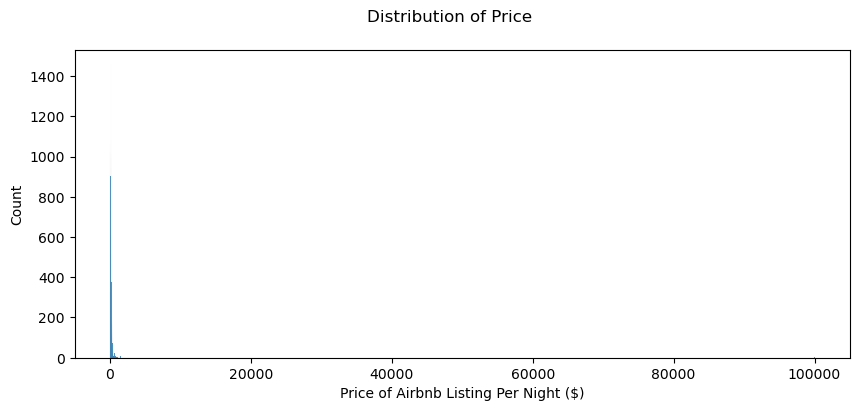

In [11]:
# plot the distribution of Price
plt.figure(figsize=(10, 4))
sns.histplot(aircopy, x="price")
plt.suptitle("Distribution of Price")
plt.xlabel("Price of Airbnb Listing Per Night ($)")
plt.ylabel("Count")
plt.show()

# there are some high outliers -> zoom into the area with more data points

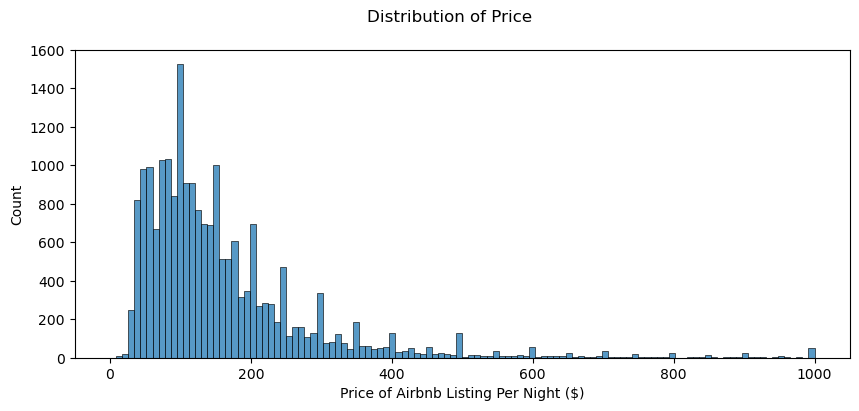

In [12]:
# plot the distribution of Price with binrange
plt.figure(figsize=(10, 4))
sns.histplot(aircopy, x="price", binrange=(0,1000))
plt.suptitle("Distribution of Price")
plt.xlabel("Price of Airbnb Listing Per Night ($)")
plt.ylabel("Count")
plt.show()

# setting a max price of 500 allows a clearer picture of most of the price data,
# a threshold of 1000 could work too

In [13]:
len( aircopy[ (airbnb_df["price"] > 500) ] )

# finding the amount of rows that are ignored by the binrange, 730 rows have prices over $500 and are not seen in the above plot
# -> these might be dealt with in future feature engineering (such as creating a dummy variable for price outliers)
# -> only 3.52% of listings have price over $500, future analysis will likely remove to focus on prices less than $500

730

In [14]:
730/20758 * 100

3.516716446671163

#### Rating (possible target variable)
The rating values range from 1.75 to 5.0. This represents the rating that the renter gave the listing, with the option to rate as low as a 1 and as high as a 5. The rating column also contains some non-numeric values including "No rating" and "New ". For the numeric ratings, the distribution is left-skewed with most of the ratings falling between 4 and 5, with a peak at the ceiling value of 5. 

In [15]:
aircopy["rating"].value_counts()

# currently the rating column is in object datatype, which makes it difficult to manipulate, 
# although most of the rows are numeric, some rows contain text such as "No rating" and "New"
# -> depending on future algo, text rows can be changed to null or imputed with an avg value

rating
No rating    3593
5.0          2882
4.67          517
4.75          469
4.80          439
             ... 
4.02            1
3.42            1
3.73            1
3.26            1
2.75            1
Name: count, Length: 162, dtype: int64

In [16]:
# subsetting into a smaller df to only contain rows with numeric
air_rating = aircopy[ (aircopy["rating"] != "No rating") & (aircopy["rating"] != "New ") ]

In [17]:
# convert rating column to type float
air_rating["rating"] = air_rating["rating"].astype(float)

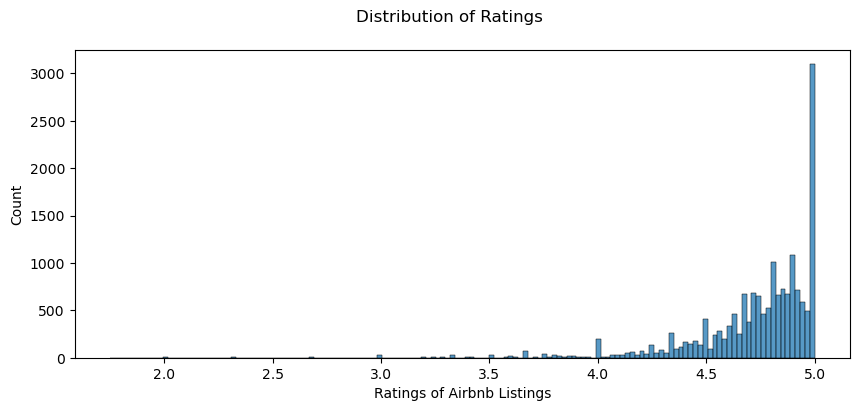

In [18]:
# plot the distribution of ratings
plt.figure(figsize=(10,4))
sns.histplot(air_rating, x="rating")
plt.suptitle("Distribution of Ratings")
plt.xlabel("Ratings of Airbnb Listings")
plt.ylabel("Count")
plt.show()

# there is a high count of ratings at the ceiling rating of 5.0,
# the rest of the ratings are mostly between 4 and 5, with a left-skew

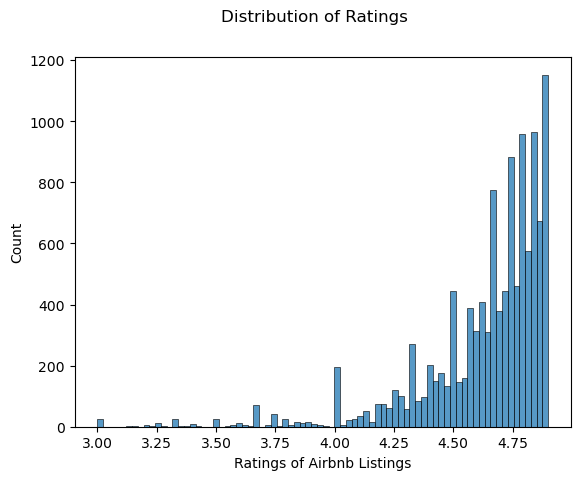

In [19]:
# plot the distribution of ratings, omitting 5.0 and zooming in to at least 3.0
plt.figure()
sns.histplot(air_rating, x="rating", binrange=(3, 4.9))
plt.suptitle("Distribution of Ratings")
plt.xlabel("Ratings of Airbnb Listings")
plt.ylabel("Count")
plt.show()

# this plot shows less outliers and likely has more predictive power

### Explore Independent Features

In [20]:
aircopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   name                            20758 non-null  object 
 2   host_id                         20758 non-null  int64  
 3   host_name                       20758 non-null  object 
 4   neighbourhood_group             20758 non-null  object 
 5   neighbourhood                   20758 non-null  object 
 6   latitude                        20758 non-null  float64
 7   longitude                       20758 non-null  float64
 8   room_type                       20758 non-null  object 
 9   price                           20758 non-null  float64
 10  minimum_nights                  20758 non-null  int64  
 11  number_of_reviews               20758 non-null  int64  
 12  last_review                     

#### Name column
The name column contains the name of the listing. It could be used for a simple NLP, to mine frequent words in the listing name, however for current modeling purposes, it does not add much information or description and was dropped.

In [21]:
# looking into column name
aircopy["name"].head(10)

# does not look like name column adds much information or description
# -> could be used for simple NLP, such as word cloud, could also be sifted further for a binary or dummy variable
# -> for current purposes, will be dropped from modeling

0           Rental unit in Brooklyn · ★5.0 · 1 bedroom
1    Rental unit in New York · ★4.67 · 2 bedrooms ·...
2    Rental unit in New York · ★4.17 · 1 bedroom · ...
3    Rental unit in New York · ★4.64 · 1 bedroom · ...
4    Condo in New York · ★4.91 · Studio · 1 bed · 1...
5    Rental unit in New York · ★5.0 · 1 bedroom · 1...
6    Rental unit in New York · ★4.33 · Studio · 1 b...
7    Rental unit in New York · ★4.50 · 2 bedrooms ·...
8    Rental unit in Brooklyn · ★4.79 · 1 bedroom · ...
9    Rental unit in Brooklyn · ★4.67 · 1 bedroom · ...
Name: name, dtype: object

#### Host id column
The host id column contains 12,449 unique host ids, with 9,625 hosts with only one listing and 336 hosts with more than five listings. 

In [22]:
# looking into column host_id

# aircopy["host_id"].value_counts()

aircopy["host_id"].nunique()

# 12,449 unique host_ids

12449

In [23]:
len(aircopy["host_id"].value_counts().loc[lambda x: x==1])

len(aircopy["host_id"].value_counts().loc[lambda x: x>5])

# 9,625 hosts have only 1 listing
# 336 hosts with greater than 5 listings

336

#### Host name column
The host name column contains 5,815 unique host names.

In [24]:
# looking into host_name

aircopy["host_name"].nunique()

# 5,815 unique host_names, can further explore why mismatch with host_ids
# -> most likely less predictive in regression models and likely won't be used
# -> for current purposes, will be dropped from modeling

5815

#### Neighbourhood group
This neighbourhood group column contains the NYC borough of the listing. With most of the listings in Manhattan and Brooklyn, and the rest of the listings in Queens, Bronx, and Staten Island. 

In [25]:
# looking into neighborhood group

aircopy["neighbourhood_group"].value_counts()

# shows the count of listings by nyc boroughs; highest is Manhattan, then Brooklyn, Queens, Bronx, Staten Island
# -> will likely be turned into dummy variables

neighbourhood_group
Manhattan        8038
Brooklyn         7719
Queens           3761
Bronx             949
Staten Island     291
Name: count, dtype: int64

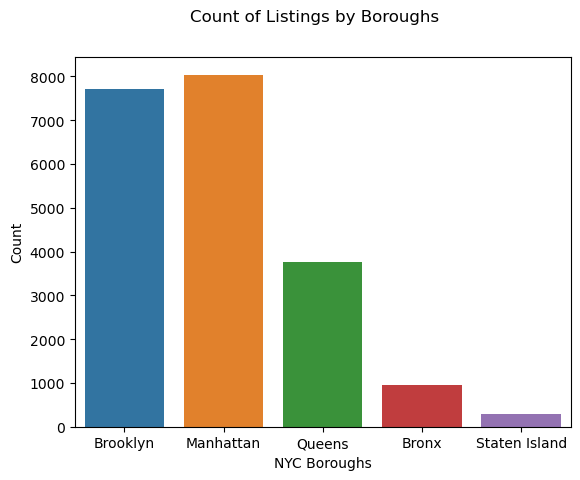

In [26]:
# plot the histogram of Listings by NYC Boroughs
plt.figure()
sns.countplot(aircopy, x="neighbourhood_group")
plt.suptitle("Count of Listings by Boroughs")
plt.xlabel("NYC Boroughs")
plt.ylabel("Count")
plt.show()

# more clearly shows that Manhattan and Brooklyn are similar in frequency

#### Neighborhood
There are 221 unique neighbourhoods, with the top neighbourhoods being Bedford-Stuyvesant, Harlem, Williamsburge, Midtown, and Hell's Kitchen.

In [27]:
# looking into neighborhood
aircopy["neighbourhood"].value_counts()

# there are many neighborhoods
# -> likely too many neighborhoods for dummy variables
# -> will try to feature engineer new column of avg neighborhood price

neighbourhood
Bedford-Stuyvesant            1586
Harlem                        1063
Williamsburg                   969
Midtown                        942
Hell's Kitchen                 867
                              ... 
Lighthouse Hill                  1
Bay Terrace, Staten Island       1
Navy Yard                        1
Neponsit                         1
Chelsea, Staten Island           1
Name: count, Length: 221, dtype: int64

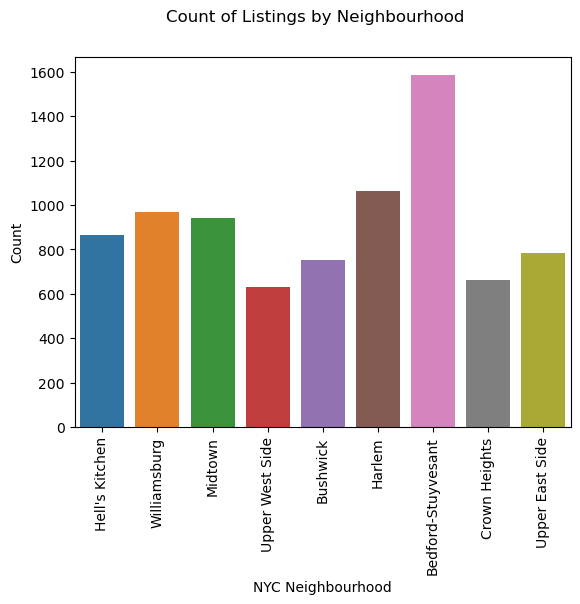

In [28]:
# plot the histogram of neighborhoods

# create filter for only value counts over 500 to see top neighborhoods
neighborhood_counts = aircopy["neighbourhood"].value_counts()
filtered_neighborhoods = neighborhood_counts[neighborhood_counts >= 500].index
filtered_neigh_df = aircopy[aircopy["neighbourhood"].isin(filtered_neighborhoods)]

plt.figure()
sns.countplot(filtered_neigh_df, x="neighbourhood")
plt.suptitle("Count of Listings by Neighbourhood")
plt.xlabel("NYC Neighbourhood")
plt.xticks(rotation=90)
plt.ylabel("Count")

plt.show()


#### Latitude and Longitude columns
Latitude and longitude can be further explored in the future if found helpful for the model. 

#### Room type column 
The room type column values were mostly "Entire home/apt" (11,549), "Private room" (8,804), "Shared room" (293), and "Hotel room" (112). This indicates that most renters and hosts preferred privacy, as most of the listings were either entire places or private rooms.

In [29]:
# looking into room_type
aircopy["room_type"].value_counts()


room_type
Entire home/apt    11549
Private room        8804
Shared room          293
Hotel room           112
Name: count, dtype: int64

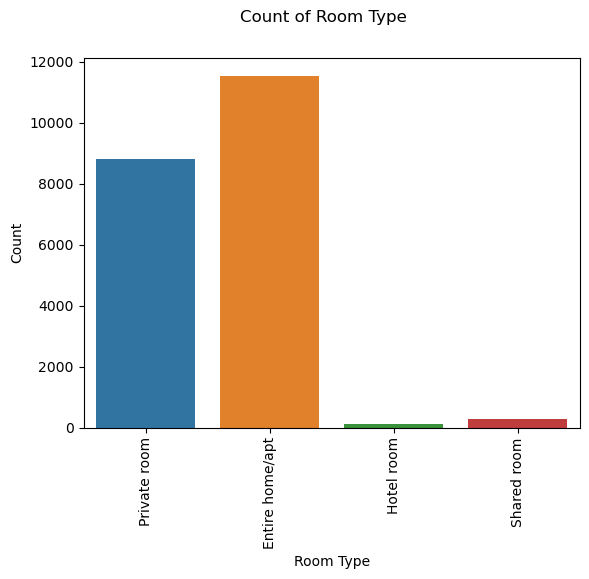

In [30]:
# plot room_type
plt.figure()
sns.countplot(aircopy, x="room_type")
plt.suptitle("Count of Room Type")
plt.xlabel("Room Type")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

#### Minimum nights column
The minimum number of nights range from 1 to 1,250, with the most frequent value being 30 (a monthly rental), and 1 (a one-night rental). 

In [31]:
# looking into minimum number of nights
aircopy["minimum_nights"].value_counts()

# surprisingly, the minimum night with highest count is 30 nights, monthly rental
# the next highest is 1 night
# -> could feature engineer into binning

minimum_nights
30     16841
1       1529
2        656
3        471
31       353
       ...  
65         1
64         1
19         1
115        1
62         1
Name: count, Length: 69, dtype: int64

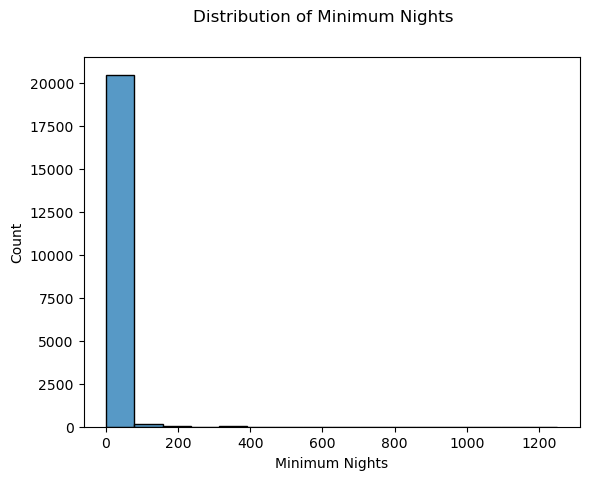

In [32]:
# plot the distribution of minimum nights
plt.figure()
sns.histplot(aircopy, x="minimum_nights")
plt.suptitle("Distribution of Minimum Nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Count")
plt.show()

# 1 to about 80 nights are binned together
# -> change binrange

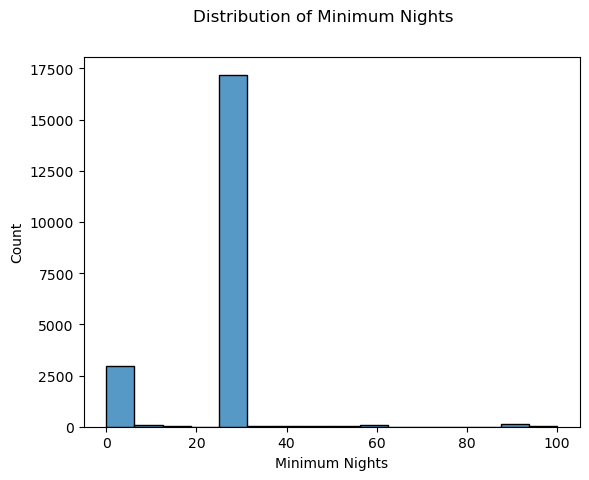

In [33]:
# plot the distribution of minimum nights with binrange 0-100
plt.figure()
sns.histplot(aircopy, x="minimum_nights", binrange=(0, 100))
plt.suptitle("Distribution of Minimum Nights")
plt.xlabel("Minimum Nights")
plt.ylabel("Count")
plt.show()

# mostly two peaks ard 30-night, and 1-night
# -> not a normal dist, should be featured engineered

#### Number of reviews column
The number of reviews column range from 1 to 1,865 reviews, with most listings having less than 150 reviews. This column displays an exponential decay distribution and suffers from extreme outliers.

In [34]:
aircopy["number_of_reviews"].max()

1865

In [35]:
# looking into number of reviews
aircopy["number_of_reviews"].value_counts()

number_of_reviews
1      2329
2      1429
3      1085
4       862
5       764
       ... 
266       1
319       1
428       1
542       1
412       1
Name: count, Length: 470, dtype: int64

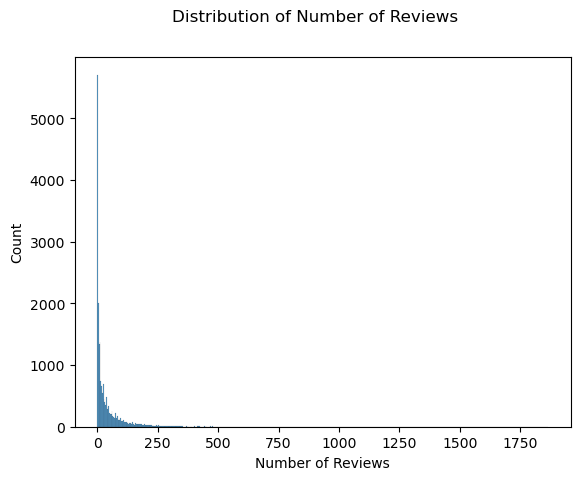

In [36]:
# plot the distribution of number of reviews
plt.figure()
sns.histplot(aircopy, x="number_of_reviews")
plt.suptitle("Distribution of Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.show()

# exponential distribution, will zoom in

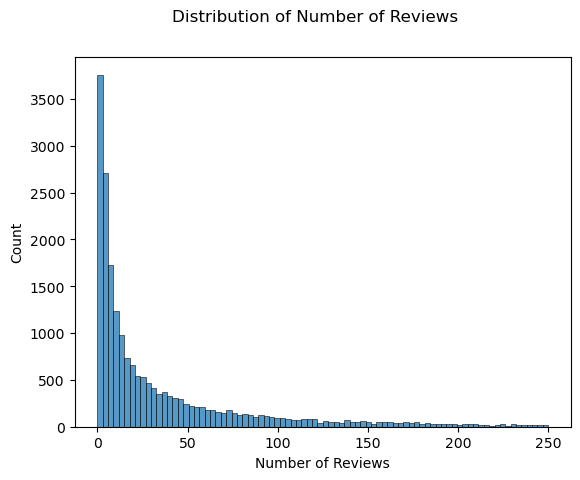

In [37]:
# plot the distribution of number of reviews with binrange
plt.figure()
sns.histplot(aircopy, x="number_of_reviews", binrange=(0,250))
plt.suptitle("Distribution of Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.show()

# clearer exponential curve
# -> could use a form of transformation

#### Last review column
The last review column shows the date the last review for this listing was written. When plotted by month, the frequency of last review gradually increased from February to December. This might indicate that the data was collected in mid-January, which would make December the most recent full month for reviews.  

In [38]:
# convert last_review from datatype object to datetime
aircopy["last_review"] = pd.to_datetime(aircopy["last_review"])

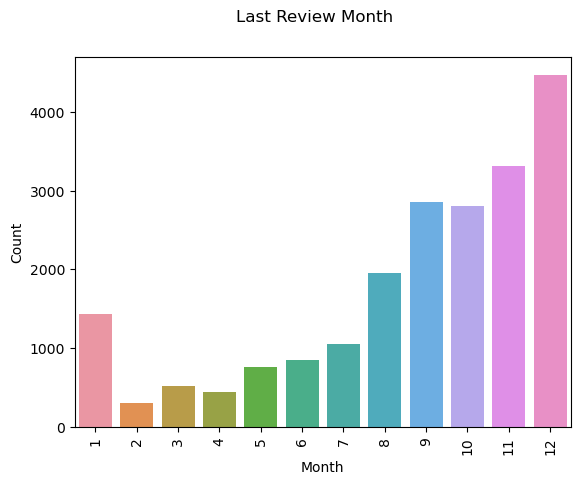

In [39]:
# plot last review

# create month col to plot
aircopy["month"] = aircopy["last_review"].dt.month

plt.figure()
sns.countplot(aircopy, x="month")
plt.suptitle("Last Review Month")
plt.xlabel("Month")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# interesting trend of gradual increase starting from Feb, look into data collection date
# -> futhur analysis can change dt.month to dt.month_name()

#### Reviews per month column
The reviews per month is an average number of reviews that the listing received each month, the values range from 0.01 to 75.49 reviews per month. With most receiving less than 10 reviews per month. The distribution shows an exponential decay curve, with extreme outliers. 

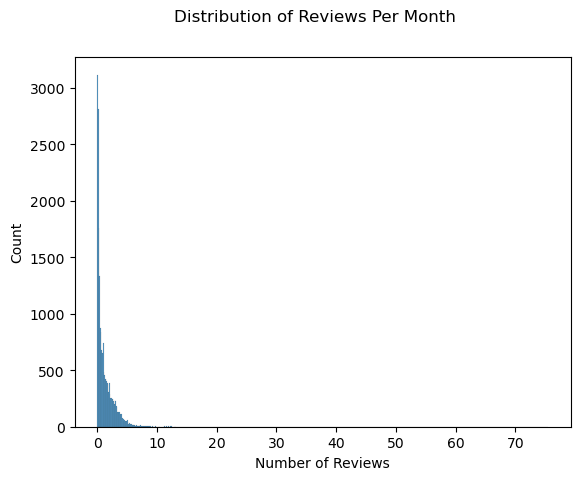

In [40]:
# plot the distribution of reviews per month 
plt.figure()
sns.histplot(aircopy, x="reviews_per_month")
plt.suptitle("Distribution of Reviews Per Month")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.show()

# too condensed, will zoom in

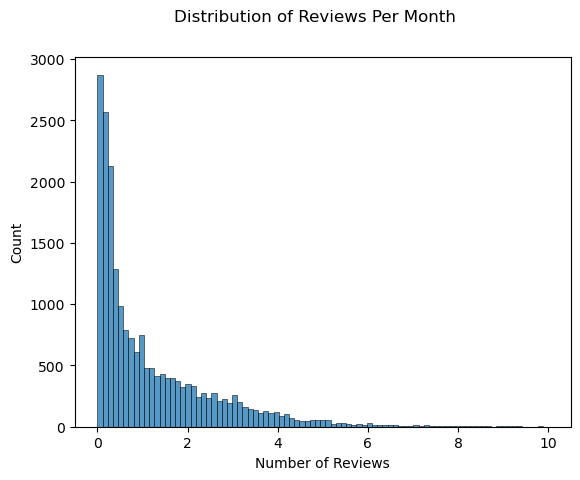

In [41]:
# plot the distribution of reviews per month with binrange 10
plt.figure()
sns.histplot(aircopy, x="reviews_per_month", binrange=(0,10))
plt.suptitle("Distribution of Reviews Per Month")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.show()

# looks much better zoomed in, seems like an exponential curve
# -> further analysis could use exponential transformer

#### Host listings column
The calculated host listings count column contains information on how many listings each host posts onto the platform. Most hosts list only one listing. 

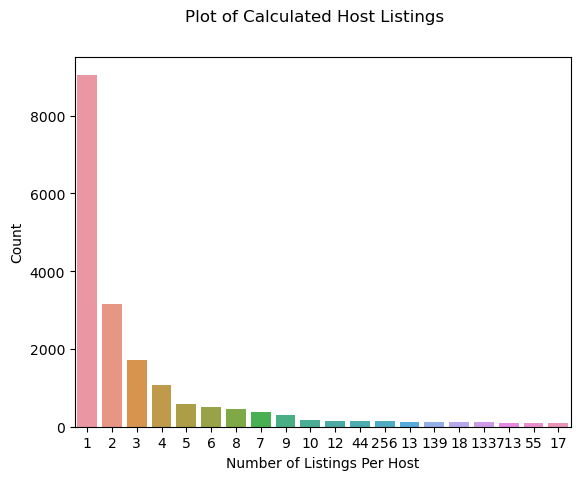

In [42]:
# look into calculated host listings
order_desc = aircopy["calculated_host_listings_count"].value_counts().index

# plot 
plt.figure()
sns.countplot(aircopy,
            x="calculated_host_listings_count",
            order=order_desc[:20])
plt.suptitle("Plot of Calculated Host Listings")
plt.xlabel("Number of Listings Per Host")
plt.ylabel("Count")
plt.show()


#### Availability 365 column
This column indicates how many days out of the year the listing was posted as availabe for guests to book. An availability of 0 indicates that the listing was not available for guests to book in the last year, and an availability of 365 indicates that the property was available year-round for guests to book, without having any days blocked off. In this dataset, the most frequent availability are 365 and 0. Further analysis could look into handling or removing rows with an availability of 0, as these properties were not available in the last year.

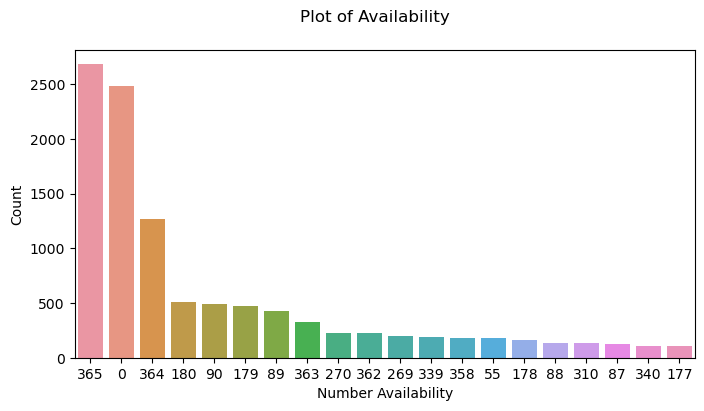

In [43]:
# look into availability
order_desc = aircopy["availability_365"].value_counts().index

# plot 
plt.figure(figsize=(8,4))
sns.countplot(aircopy,
            x="availability_365",
            order=order_desc[:20])
plt.suptitle("Plot of Availability")
plt.xlabel("Number Availability")
plt.ylabel("Count")
plt.show()

# availability 365 and 0 are most common
# -> could use feature eng. perhaps binning

#### Number of reviews (last twelve months) column
This column normalizes the number of reviews by limiting the time limit to the last twelve months. Some listings that have been listed for a longer period of time can accumulate more listings overall, and this column shows which listings have been more popularly reviewed in the last twelve months. This column indicates that many listings are not very often reviewed, with many listings receiving 0 to 5 reviews in the last twelve months.

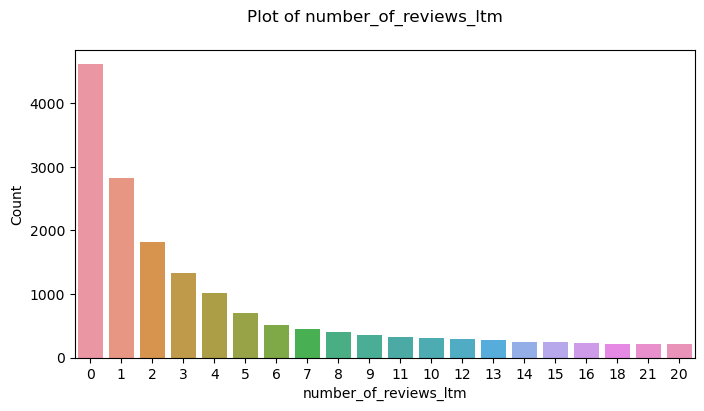

In [44]:
# look into number of reviews ltm
order_desc = aircopy["number_of_reviews_ltm"].value_counts().index

# plot 
plt.figure(figsize=(8,4))
sns.countplot(aircopy,
            x="number_of_reviews_ltm",
            order=order_desc[:20])
plt.suptitle("Plot of number_of_reviews_ltm")
plt.xlabel("number_of_reviews_ltm")
plt.ylabel("Count")
plt.show()

# another exponential curve
# -> could use an exponential transformation

#### License column
The license column indicates whether a listing has "No license," is license "Exempt," or has a license number. Most of the listings do not have a license (17,569). 

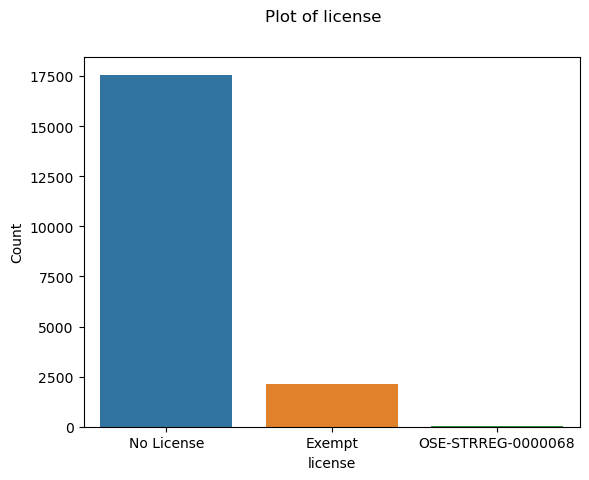

In [45]:
# look into license
order_desc = aircopy["license"].value_counts().index

# plot 
plt.figure()
sns.countplot(aircopy,
            x="license",
            order=order_desc[:3])
plt.suptitle("Plot of license")
plt.xlabel("license")
plt.ylabel("Count")
plt.show()

# most listings do no have a license
# -> could group all of the licenses together into Has_license group

#### Bedrooms column
The bedrooms column shows that most listings are of average size and have between 0 (studio) and five bedrooms, with the most common having one bedroom. 

In [46]:
# look into bedrooms
airbnb_df["bedrooms"].value_counts()

# -> further analysis could change Studio to 0, and convert col to dtype int

bedrooms
1         13439
2          3602
Studio     1815
3          1394
4           345
5           112
6            29
7             9
9             6
8             5
15            1
14            1
Name: count, dtype: int64

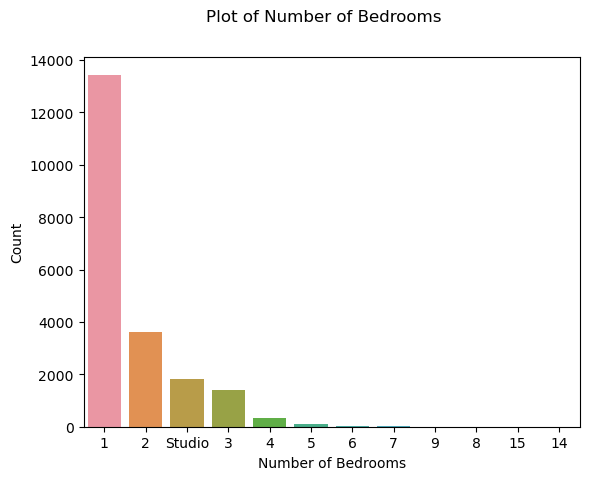

In [47]:
# plot Bedrooms
order_desc = aircopy["bedrooms"].value_counts().index

plt.figure()
sns.countplot(aircopy, x="bedrooms", order=order_desc)
plt.suptitle("Plot of Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")
plt.show()

#### Beds column
The beds column has an exponential decay curve, with most listings having only one bed. However, this column also suffers from extreme outliers, with a listing having as many as 42 beds. 

In [48]:
airbnb_df["beds"].value_counts()

beds
1     12310
2      4834
3      2029
4       929
5       335
6       162
7        63
8        49
9        22
10       11
12        5
11        4
21        1
14        1
13        1
18        1
42        1
Name: count, dtype: int64

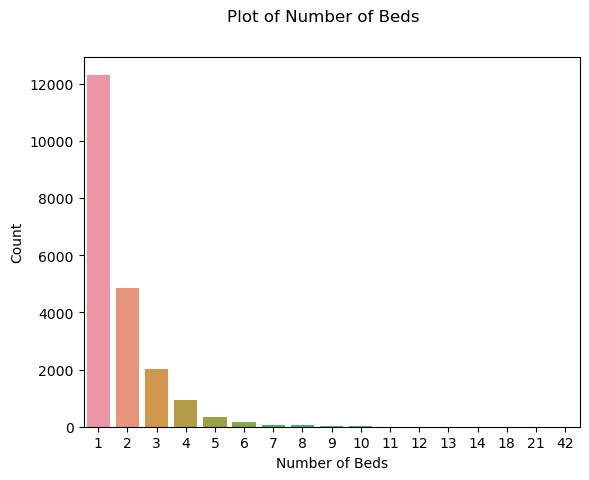

In [49]:
# plot number of beds

plt.figure()
sns.countplot(aircopy, x="beds")
plt.suptitle("Plot of Number of Beds")
plt.xlabel("Number of Beds")
plt.ylabel("Count")
plt.show()

#### Baths column
All listings have at least one bath, with most having exactly one bath (17,015), although some listings have more, up to an outlier amount of 15.5 baths. This column also suffers from extreme outliers and could be handled in further analysis.

In [50]:
# look into baths
airbnb_df["baths"].value_counts()

# -> further analysis can impute value for number of baths that are "Not specified"

baths
1                17015
2                 2082
1.5               1001
2.5                240
3                  171
0                   82
4                   69
3.5                 50
4.5                 18
Not specified       13
5                    6
6                    4
5.5                  2
6.5                  2
11.5                 1
7                    1
15.5                 1
Name: count, dtype: int64

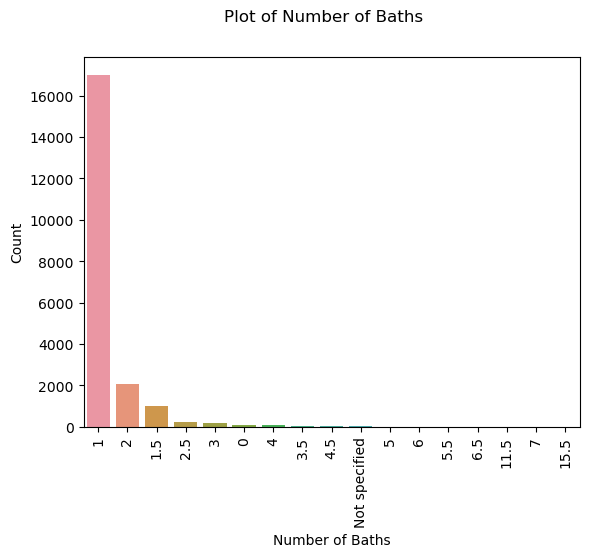

In [51]:
# plot number of baths
order_desc = aircopy["baths"].value_counts().index

plt.figure()
sns.countplot(aircopy, x="baths", order=order_desc)
plt.suptitle("Plot of Number of Baths")
plt.xlabel("Number of Baths")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# this dataset looks like it has outliers for very large places with over 5 baths
# -> further analysis can experiment with modeling without outiers

### Bivariate Exploration

#### Scatterplot of price and rating
In this scatterplot between price and rating, the plot shows that there could be a positive relationship between price and rating. It seems that for listings under \\$500, the ratings can range, but for expensive listings over \\$500, then they tend to have higher ratings.

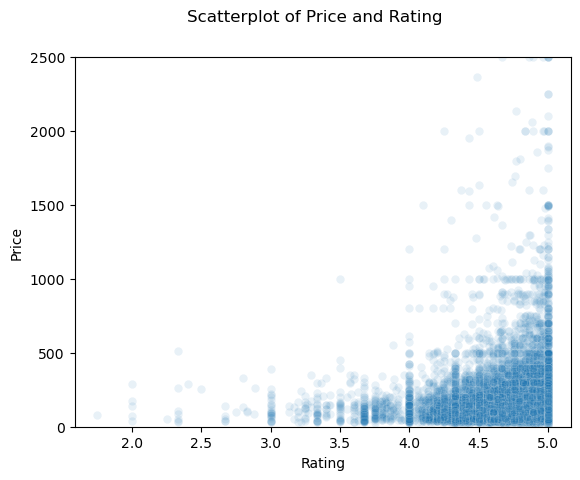

In [52]:
# scatterplot of price and rating
plt.figure()
sns.scatterplot(aircopy, x=air_rating["rating"], y="price", alpha=.1)
plt.suptitle("Scatterplot of Price and Rating")
plt.ylim(0, 2500)
plt.xlabel("Rating")
plt.ylabel("Price")
plt.show()

# looks like there is a relationship, some form of positive correlation

#### Boxplot of price and beds
As the number of beds increases, the price also tends to increase. Listings with less beds tend to have a smaller quartile range, being more predictable with price. 

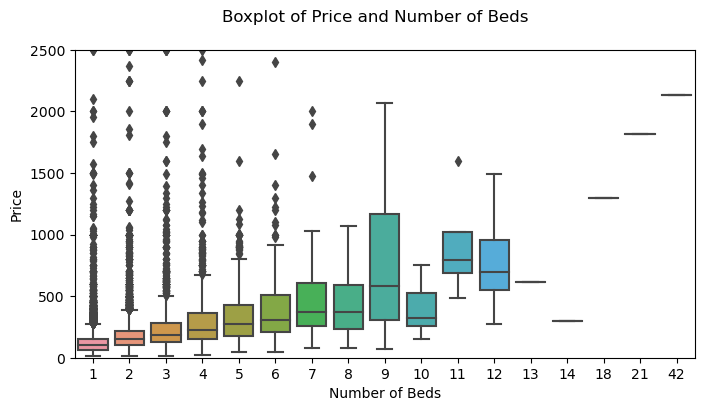

In [53]:
# boxplot of price and beds
plt.figure(figsize=(8,4))
sns.boxplot(aircopy, x="beds", y="price")
plt.suptitle("Boxplot of Price and Number of Beds")
plt.ylim(0, 2500)
plt.xlabel("Number of Beds")
plt.ylabel("Price")
plt.show()

# the trend for price and number of beds is clear from 1-8 beds, after 9 beds, it is more sporadic
# -> further analysis could handle 9+ beds

#### Lineplot of price and month
The lineplot of price and month show a slightly higher average price for March and October. Further analysis could look into whether this is a consistent seasonal trend or if there are outiers bringing up the price for those months.

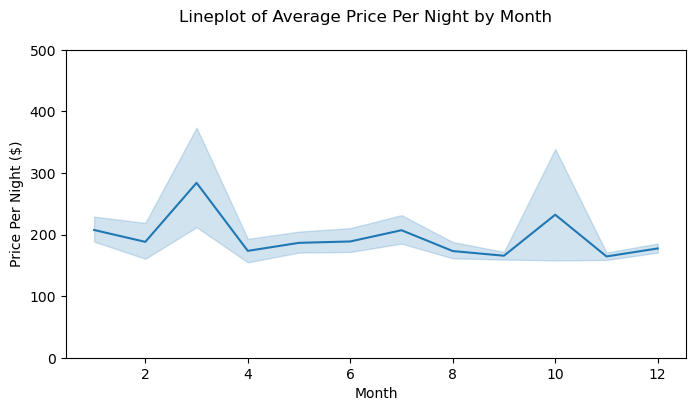

In [54]:
# lineplot of price and month
plt.figure(figsize=(8,4))
sns.lineplot(aircopy, x="month", y="price")
plt.suptitle("Lineplot of Average Price Per Night by Month")
plt.ylim(0, 500)
plt.xlabel("Month")
plt.ylabel("Price Per Night ($)")
plt.show()

# March and October has a slightly higher average
# -> further analysis could look into deeper granularity and look into holidays, etc

### Write dataframe to CSV

In [55]:
# write to csv to be accessed in next notebook
aircopy.to_csv("../data/eda_airbnb.csv", index=False)